<a href="https://colab.research.google.com/github/omkar-thite/used_car_regression_kaggle/blob/main/used_car_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [89]:
# Import required libraries
import numpy as np
import pandas as pd
import re
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.cluster import KMeans
import shap
import random

In [90]:
RANDOM_STATE = 35

In [91]:
df = pd.read_csv('train.csv', delimiter=',')

In [92]:
df.head()

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200
1,1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999
2,2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900
3,3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000
4,4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500


In [93]:
# Check for missing values
print(f'missing data: {df.isnull().sum()}')

missing data: id                  0
brand               0
model               0
model_year          0
milage              0
fuel_type        5083
engine              0
transmission        0
ext_col             0
int_col             0
accident         2452
clean_title     21419
price               0
dtype: int64


In [94]:
# Make price and milage float for furthur treatment
df['price']=df['price'].astype('float')
df['milage'] = df['milage'].astype('float')

In [95]:
# Treat missing initial categorical variables with mode imputer
def df_missing_cat(df):
    categorical_attributes = df.select_dtypes(include=[int, object]).columns.tolist()
    print(f'categorical attributes: {categorical_attributes}')

    categorical_data_missing = [attr for attr in categorical_attributes if df[attr].isnull().any()]
    print(f'Missing categories: {categorical_data_missing}')

    # Impute categorical features with mode
    mode_imputer = SimpleImputer(strategy='most_frequent')
    df[categorical_data_missing] = mode_imputer.fit_transform(df[categorical_data_missing])

    return df

In [96]:
df = df_missing_cat(df)

categorical attributes: ['id', 'brand', 'model', 'model_year', 'fuel_type', 'engine', 'transmission', 'ext_col', 'int_col', 'accident', 'clean_title']
Missing categories: ['fuel_type', 'accident', 'clean_title']


In [97]:
# Categorical: Int, object: Won't be scaled and will be applied mode Imputer
# Continuos: Float, float64:  Will be Scaled, applied mean Imputer

# Feature Engineering

Functions to extract features from original dataset

In [98]:
# Categorical
def get_automatic(string):
    string = string.lower()
    if 'a/t' in string or 'automatic' in string or 'at' in string:
        return 1
    else:
        return 0

In [99]:
# Categorical
def get_gears(string):
    match = re.search(r'^(\d+)-Speed', string, re.IGNORECASE)
    if match:
        gears = match.group(1)
        return int(gears)
    else:
        return None

In [100]:
# Contiunuos
def get_hp(engine):
    match = re.search(r'([\d.]+)HP', engine, re.IGNORECASE)
    if match:
      return float(match.group(1))
    else:
      return None

In [101]:
# Continuos
def get_L(engine):
    match = re.search(r'([\d.]+)L', engine, re.IGNORECASE)
    if match:
      return float(match.group(1))
    else:
      return None

In [102]:
# Categorical
def get_cyl(engine):
    match = re.search(r'([\d.]+)?\s?(?:Cylinder|Cyl|Cylinders)', engine, re.IGNORECASE)
    if match:
      return int(match.group(1))
    else:
      return None

In [103]:
# Categorical
def is_electric(engine):
    if 'electric' in engine.lower():
      return 1
    else:
      return 0

In [104]:
# Continuos
def num_valves(engine):
    match = re.search(r'([\d+])V', engine)
    if match:
      return float(match.group(1))
    else:
      return None

In [105]:
# Categorical
def is_accident(accident):
    if type(accident) == str:
        if 'accident' in accident.lower():
          return 1
        else:
          return 0
    else:
        return None

Functions to extract featurs

In [106]:
# Create features and insert into dataframe
def create_features(df):
    ''' Returns dataframe with newly created features '''
    df['automatic'] = df['transmission'].apply(get_automatic)
    df['gears'] = df['transmission'].apply(get_gears)
    df['hp'] = df['engine'].apply(get_hp)
    df['L'] = df['engine'].apply(get_L)
    df['cylinders'] = df['engine'].apply(get_cyl)
    df['accident'] = df['accident'].apply(is_accident)
    df['electric'] = df['engine'].apply(is_electric)
    df['valves'] = df['engine'].apply(num_valves)
    return df

def create_interactions(df):
    ''' Returns dataframe with newly created interaction features'''
    df['hp/l'] = np.where(df['L'] != 0, df['hp'] / df['L'], None).astype('float')
    df['mil/l'] = np.where(df['L'] != 0, df['milage'] / df['L'], None).astype('float')
    df['mil/hp'] = np.where(df['hp'] != 0, df['milage'] / df['hp'], None).astype('float')
    df['l/cyl'] = np.where(df['cylinders'] != 0, df['L'] / df['cylinders'], None).astype('float')
    df['hp/gears'] = np.where(df['gears'] != 0, df['hp'] / df['gears'], None).astype('float')
    df['mil/gears'] = np.where(df['gears'] != 0, df['milage'] / df['gears'], None).astype('float')
    df['mil/cyl'] = np.where(df['cylinders'] != 0, df['milage'] / df['cylinders'], None).astype('float')

    df['hp*automatic'] = df['hp'] * df['automatic']
    df['cyl*gears'] = df['cylinders'] * df['gears']

    df['carAge'] = df['model_year'] - 2024
    df['mil/year'] = np.where(df['carAge'] != 0, df['milage'] / df['carAge'], None).astype('float')
    df['hp*accident'] = df['hp'] * df['accident']
    df['accident*carAge'] = df['accident'] * df['carAge']
    df['acc*milage'] = df['accident'] * df['milage']

    df['mil*carAge'] = df['milage'] * df['carAge']
    df['hp*mil'] = df['hp'] * df['milage']
    return df

In [107]:
df = create_features(df)

In [108]:
# Create a list to track categorical variables
# We will treat some suitable variables as categorical
new_categoricals = list(df.select_dtypes(include=[int, object]).columns)
new_categoricals.extend(['L', 'cylinders', 'gears'])
new_categoricals.remove('id')
new_categoricals

['brand',
 'model',
 'model_year',
 'fuel_type',
 'engine',
 'transmission',
 'ext_col',
 'int_col',
 'accident',
 'clean_title',
 'automatic',
 'electric',
 'L',
 'cylinders',
 'gears']

### Treat missing values of variables

In [109]:
print(df.isnull().sum())

id                   0
brand                0
model                0
model_year           0
milage               0
fuel_type            0
engine               0
transmission         0
ext_col              0
int_col              0
accident             0
clean_title          0
price                0
automatic            0
gears            84434
hp               33259
L                14214
cylinders        37855
electric             0
valves          165115
dtype: int64


In [110]:
# Treat categorical missing values
def df_missing_new_cat(df, new_categoricals):
    ''' Applies mode imputer to categorical missing values '''
    categorical_features_missing = [col for col in new_categoricals if df[col].isnull().any()]
    print(f'Categorical missing features: {categorical_features_missing}')

    mode_imputer = SimpleImputer(strategy='most_frequent')
    df[categorical_features_missing] = mode_imputer.fit_transform(df[categorical_features_missing])
    return df

In [111]:
df = df_missing_new_cat(df, new_categoricals)
print(df.isnull().sum())

Categorical missing features: ['L', 'cylinders', 'gears']
id                   0
brand                0
model                0
model_year           0
milage               0
fuel_type            0
engine               0
transmission         0
ext_col              0
int_col              0
accident             0
clean_title          0
price                0
automatic            0
gears                0
hp               33259
L                    0
cylinders            0
electric             0
valves          165115
dtype: int64


In [112]:
# Treat continuos missing values
def df_missing_cont(df, new_categoricals):
    ''' Applies mean imputer to continuos variables with missing values '''
    continuos_features_missing = [col for col in df.columns if col not in new_categoricals and df[col].isnull().any()]
    print(f'Missing continuos features: {continuos_features_missing}')

    mean_imputer = SimpleImputer(strategy='mean')
    df[continuos_features_missing] = mean_imputer.fit_transform(df[continuos_features_missing])
    return df

In [113]:
df = df_missing_cont(df, new_categoricals)

Missing continuos features: ['hp', 'valves']


In [114]:
print( df.isnull().sum())

id              0
brand           0
model           0
model_year      0
milage          0
fuel_type       0
engine          0
transmission    0
ext_col         0
int_col         0
accident        0
clean_title     0
price           0
automatic       0
gears           0
hp              0
L               0
cylinders       0
electric        0
valves          0
dtype: int64


### Create Interaction features

In [115]:
# Create interaction features
df = create_interactions(df)

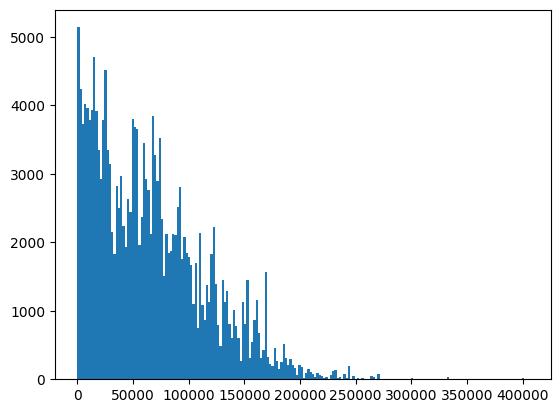

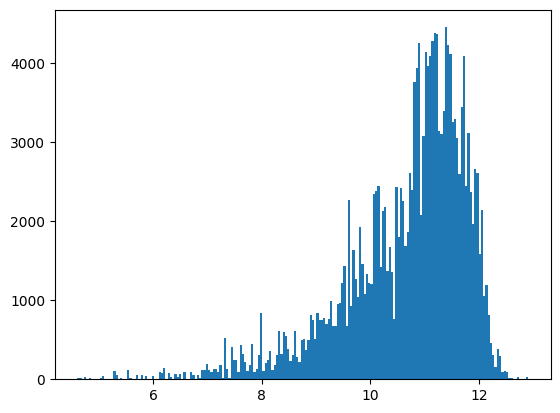

In [116]:
# See milage distribution
plt.hist(df['milage'], bins=200)
plt.show();

# milage is right skewed. Log transformation could be used.
log_milage = np.log(df['milage'])
plt.hist(log_milage, bins=200)
plt.show()

In [117]:
# Add binning to milage and categorize ordinally

# Get range of values
print(np.min(df['milage']), np.max(df['milage']))

bins = [99.0, 1000.0, 10000.0, 50000.0, 100000.0, 300000.0, 500000.0]

binned_milage = pd.cut(df['milage'], bins, right=False)

# mils_bins_category is dict of structure {interval: int} where int is increasing from 0 to 5: there are 6 Intervals
mils_bins_category = {}
for i in range(0, len(bins) - 1, 1):
    mils_bins_category[pd.Interval(bins[i], bins[i+1], closed='left')] = i

100.0 405000.0


In [118]:
# Assign classes to brands according to their mean prices
# Classes are of type int, ordinally categorized

# Get range of values
print(np.min(df['price']), np.max(df['price']))

bins = [1000.0, 5000.0, 10000.0, 25000.0, 50000.0, 100000.0, 150000.0, 200000.0, 250000.0, 300000.0]

binned_prices = pd.cut(df['price'], bins, right=False) # 9 Intervals

# Create bins category mapping
bins_category = {pd.Interval(bins[i], bins[i+1], closed='left'): i for i in range(len(bins) - 1)}

# Create dict {'brand_name' : mean_price}
brand_avg_price = df.groupby('brand')['price'].mean().to_dict()


def get_class(mprice):
    ''' Returns category of mean price
    Args:
    mprice(float) : Mean price
    Returns:
    category(int): Category of interval in which mrice lies
    '''

    for interval, category in bins_category.items():
        if mprice in interval:
          return category

2000.0 2954083.0


In [119]:
def additional_features(df):
    df['AverageMilage'] = df.groupby("brand")['milage'].transform('mean')
    df['BrandFreq'] = df.groupby('brand')['brand'].transform('count')/df['brand'].count()

    brand_count = df.groupby('brand')['brand'].count().to_dict() #{'brand_name' : mean_price}
    df['brand_count'] = df['brand'].map(brand_count)

    brand_avg_mil = df.groupby('brand')['milage'].mean().to_dict() #{'brand_name' : mean_price}
    df['brand_avg_mil'] = df['brand'].map(brand_avg_mil)

    df['binned_milage'] = binned_milage.map(lambda x: mils_bins_category[x])

    brand_class = {brand: get_class(price) for brand, price in brand_avg_price.items()}
    df['brand_class'] = df['brand'].map(lambda x: brand_class[x])

    df['log_milage'] = np.log(df['milage'])


    return df

In [120]:
df = additional_features(df)

In [121]:
'''from category_encoders import BinaryEncoder
binaries = BinaryEncoder(cols=objects, drop_invariant=True).fit_transform(df)
df = df.join(binaries, rsuffix='_encoded')
df.columns'''

"from category_encoders import BinaryEncoder\nbinaries = BinaryEncoder(cols=objects, drop_invariant=True).fit_transform(df)\ndf = df.join(binaries, rsuffix='_encoded')\ndf.columns"

In [122]:
# Check for missing values
print(df.isnull().sum())

id                   0
brand                0
model                0
model_year           0
milage               0
fuel_type            0
engine               0
transmission         0
ext_col              0
int_col              0
accident             0
clean_title          0
price                0
automatic            0
gears                0
hp                   0
L                    0
cylinders            0
electric             0
valves               0
hp/l                 0
mil/l                0
mil/hp               0
l/cyl                0
hp/gears             0
mil/gears            0
mil/cyl              0
hp*automatic         0
cyl*gears            0
carAge               0
mil/year           162
hp*accident          0
accident*carAge      0
acc*milage           0
mil*carAge           0
hp*mil               0
AverageMilage        0
BrandFreq            0
brand_count          0
brand_avg_mil        0
binned_milage        0
brand_class          0
log_milage           0
dtype: int6

In [123]:
df = df_missing_cont(df, new_categoricals)

Missing continuos features: ['mil/year']


In [124]:
print(df.isnull().sum())

id                 0
brand              0
model              0
model_year         0
milage             0
fuel_type          0
engine             0
transmission       0
ext_col            0
int_col            0
accident           0
clean_title        0
price              0
automatic          0
gears              0
hp                 0
L                  0
cylinders          0
electric           0
valves             0
hp/l               0
mil/l              0
mil/hp             0
l/cyl              0
hp/gears           0
mil/gears          0
mil/cyl            0
hp*automatic       0
cyl*gears          0
carAge             0
mil/year           0
hp*accident        0
accident*carAge    0
acc*milage         0
mil*carAge         0
hp*mil             0
AverageMilage      0
BrandFreq          0
brand_count        0
brand_avg_mil      0
binned_milage      0
brand_class        0
log_milage         0
dtype: int64


In [125]:
# Label categorical features
for colname in new_categoricals:
    df[colname], _ = df[colname].factorize()

In [138]:
X = df.copy()
y = X.pop('price')

In [139]:
X.pop('id')

,id
0,0
1,1
2,2
3,3
4,4
...,...
188528,188528
188529,188529
188530,188530
188531,188531


#### PCA

In [140]:
# Standardize the data (important for PCA)
scaler_pca = StandardScaler()
X_scaled = scaler_pca.fit_transform(X.select_dtypes(include='float'))

# Apply PCA
pca = PCA(n_components=2)  # Specify the number of components
pca_components = pca.fit_transform(X_scaled)

# Explained Variance
explained_variance = np.sum(pca.explained_variance_ratio_)

print("Explained Variance Ratio:", explained_variance)

# Convert to DataFrame for better readability
pca_df = pd.DataFrame(data=pca_components, columns=['PC1', 'PC2'])
X = pd.concat([X, pca_df], axis=1)

Explained Variance Ratio: 0.4938634990185205


#### K-means Clustering

In [141]:
# Add cluster feature
c_scaler = StandardScaler()
XC = [col for col in X.columns if col not in new_categoricals]
XC = X[XC]
XC = c_scaler.fit_transform(XC)

# Create cluster feature
kmeans = KMeans(n_clusters=3, n_init=10)
X['Cluster'] = kmeans.fit_predict(XC)
X['Cluster'] = X['Cluster'].astype('category')

#### Output of a trained Ridge model as a feature

In [142]:
r_model = Ridge(alpha=1)
r_model.fit(X, y)
np.sqrt(mean_squared_error(r_model.predict(X), y))

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.74925e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


73554.05595318042

In [143]:
X['f1'] = r_model.predict(X)

In [144]:
X.shape

(188533, 45)

# Features selection

### Calculate MI scores

In [145]:
discrete_features = X.select_dtypes(include=[int, 'category'])
discrete_features = np.array([col in discrete_features for col in X.columns])
X.columns[discrete_features]

Index(['brand', 'model', 'model_year', 'fuel_type', 'engine', 'transmission',
       'ext_col', 'int_col', 'accident', 'clean_title', 'automatic', 'gears',
       'L', 'cylinders', 'electric', 'carAge', 'accident*carAge',
       'brand_count', 'binned_milage', 'brand_class', 'Cluster'],
      dtype='object')

In [146]:
def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores
print(X.shape)
print(y.shape)
mi_scores = make_mi_scores(X, y, discrete_features)

(188533, 45)
(188533,)


In [147]:
mi_scores

,MI Scores
log_milage,0.660801
milage,0.659014
engine,0.626380
mil*carAge,0.615467
mil/cyl,0.595424
mil/gears,0.589889
hp/l,0.574823
mil/hp,0.547488
carAge,0.541900
model_year,0.541900


In [148]:
mi_features = list(mi_scores.index)
mi_features[:16]

['log_milage',
 'milage',
 'engine',
 'mil*carAge',
 'mil/cyl',
 'mil/gears',
 'hp/l',
 'mil/hp',
 'carAge',
 'model_year',
 'hp',
 'hp/gears',
 'f1',
 'PC1',
 'mil/l',
 'model']

### RFE select features

In [149]:
from sklearn.feature_selection import RFE

# Recursive Feature Elimination
model = XGBRegressor(learning_rate= 0.2,
                     max_depth = 2,
                     n_estimators = 200,)
selector = RFE(model, n_features_to_select=20)
selector.fit(X, y)

# Check selected features
print(selector.support_)


[False False  True  True False  True  True  True False False False False
 False  True False False False  True  True  True  True False False  True
  True False False  True False False False False  True False  True  True
 False False False  True False  True  True False  True]


In [150]:
rfe_features = list(X.columns[list(selector.support_)])
rfe_features

['model_year',
 'milage',
 'engine',
 'transmission',
 'ext_col',
 'hp',
 'valves',
 'hp/l',
 'mil/l',
 'mil/hp',
 'mil/gears',
 'mil/cyl',
 'carAge',
 'mil*carAge',
 'AverageMilage',
 'BrandFreq',
 'brand_class',
 'PC1',
 'PC2',
 'f1']

In [151]:
# Include features based on both MI scores and RFE features
selected_features = ['hp*mil',
 'AverageMilage',
 'BrandFreq',
 'brand_class',
 'PC1',
 'PC2',
 'Cluster',
 'f1', 'log_milage',
 'milage',
 'engine',
 'mil*carAge',
 'mil/cyl',
 'mil/gears',
 'hp/l',
 'mil/hp',
 'model_year',
 'carAge',
 'hp',
 'hp/gears']

#### Grid search for parameter values for model

In [156]:
# Used to get params of model
# Set up the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [2, 3, 5],
}

# Create the model and GridSearch object
model = XGBRegressor()
grid_search = GridSearchCV(model, param_grid, cv=3)

# Fit to the training data

# Remove category dtype as per docs
X_train = X.drop(['binned_milage', 'Cluster'], axis=1)
grid_search.fit(X_train, y)

# Best hyperparameters
print(grid_search.best_params_)

{'learning_rate': 0.2, 'max_depth': 2, 'n_estimators': 100}


In [158]:
params = {'learning_rate': 0.2, 'max_depth': 2, 'n_estimators': 100}

In [157]:
model = XGBRegressor(learning_rate= 0.2,
                     max_depth = 2,
                     n_estimators = 100,)

In [159]:
# Evaluates model
def get_error(model, x_train, x_cv, y_train, y_cv):
    ypred = model.predict(x_train)
    xgb_train_mse = mean_squared_error(y_train, ypred)
    xgb_train_mse = np.sqrt(xgb_train_mse)

    ypred = model.predict(x_cv)
    xgb_cv_mse = mean_squared_error(y_cv, ypred)
    xgb_cv_mse = np.sqrt(xgb_cv_mse)

    print(f'train MSE: {xgb_train_mse}\nValidation MSE: {xgb_cv_mse}')
    print(f'Difference: {abs(xgb_train_mse - xgb_cv_mse):.4f}')

In [160]:
# Choose features to use based on MI score
def run_model(X, y, selected_features):
    '''
    Runs selected features on model, returns and plots training and validation MSEs
    '''
    train_mse = []
    val_mse = []
    m, n = X.shape

    N = range(1, len(selected_features))

    for n in N:
        x = X[selected_features[:n]]

        x_train, x_cv, y_train, y_cv = train_test_split(x, y, test_size=0.3, random_state=RANDOM_STATE)

        # Scale Training data
        scaler1 = StandardScaler()
        x_train = scaler1.fit_transform(x_train)
        x_cv = scaler1.transform(x_cv)

        model = XGBRegressor(learning_rate= 0.2,
                        max_depth = 2,
                        n_estimators = 200,)
        model.fit(x_train, y_train)

        ypred = model.predict(x_train)
        xgb_train_mse = mean_squared_error(y_train, ypred)
        train_mse.append(np.sqrt(xgb_train_mse))

        ypred = model.predict(x_cv)
        xgb_cv_mse = mean_squared_error(y_cv, ypred)
        val_mse.append(np.sqrt(xgb_cv_mse))


    plt.close('all')
    plt.plot(N, train_mse, c='r', label='training MSE')
    plt.plot(N, val_mse, c='b', label='Val MSE')
    plt.xlabel('Number of features')
    plt.ylabel('MSEs')
    plt.legend()
    plt.show()

    return train_mse, val_mse

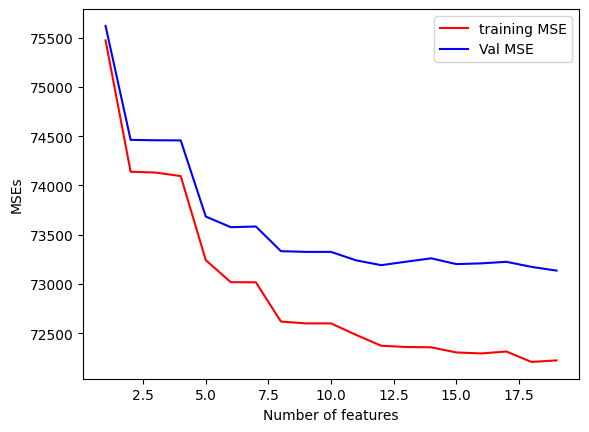

In [161]:
t , v = run_model(X, y, selected_features)

# Training

In [162]:
# Select features from MI score
# X_train = X[mi_features[:9]]

# Select features from RFE selector
X_train = X[rfe_features]

# Select features from selected features
#X_train = X[selected_features[:8]]

# From RFE
#x = X[selected_features]
X_train.shape

(188533, 20)

In [163]:
# Split dataset into training, validation and testing subsets
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y, test_size=0.3, random_state=RANDOM_STATE)

print(X_train.shape, y_train.shape)

(131973, 20) (131973,)


In [164]:
# Scale continuos features
continuos_features_to_scale = [col for col in X_train.columns if col not in new_categoricals]
print(f'Features to be scaled: {continuos_features_to_scale}')

scalerTrain = StandardScaler()
x_train = scalerTrain.fit_transform(X_train[continuos_features_to_scale])
x_cv = scalerTrain.transform(X_cv[continuos_features_to_scale])

Features to be scaled: ['milage', 'hp', 'valves', 'hp/l', 'mil/l', 'mil/hp', 'mil/gears', 'mil/cyl', 'carAge', 'mil*carAge', 'AverageMilage', 'BrandFreq', 'brand_class', 'PC1', 'PC2', 'f1']


In [165]:
# Train model
model.fit(x_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.2, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=2, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [166]:
# Calculate RMSE
ypred = model.predict(x_train)
xgb_train_mse = mean_squared_error(y_train, ypred)
np.sqrt(xgb_train_mse)

72471.80526796395

In [167]:
# Evaluate model
get_error(model, x_train, x_cv, y_train, y_cv)

train MSE: 72471.80526796395
Validation MSE: 73180.94551288233
Difference: 709.1402


### Submission

In [174]:
test = pd.read_csv('test.csv')
id = test.pop('id')
test['milage'] = test['milage'].astype('float')

In [175]:
test = df_missing_cat(test)
test = create_features(test)
test = df_missing_new_cat(test, new_categoricals)
test = df_missing_cont(test, new_categoricals)
test = create_interactions(test)
test = additional_features(test)
test = df_missing_cont(test, new_categoricals)

categorical attributes: ['brand', 'model', 'model_year', 'fuel_type', 'engine', 'transmission', 'ext_col', 'int_col', 'accident', 'clean_title']
Missing categories: ['fuel_type', 'accident', 'clean_title']
Categorical missing features: ['L', 'cylinders', 'gears']
Missing continuos features: ['hp', 'valves']
Missing continuos features: ['mil/year']


In [176]:
for colname in new_categoricals:
    test[colname], _ = test[colname].factorize()

In [177]:
test_scaled = scaler_pca.transform(test.select_dtypes(include='float'))
pca_components = pca.transform(test_scaled)

pca_df = pd.DataFrame(data=pca_components, columns=['PC1', 'PC2'])
test = pd.concat([test, pca_df], axis=1)

In [178]:
#c_scaler = StandardScaler()
XC = [col for col in test.columns if col not in new_categoricals]
XC = test[XC]
XC = c_scaler.transform(XC)

# Create cluster feature
#kmeans = KMeans(n_clusters=3, n_init=10)
test['Cluster'] = kmeans.fit_predict(XC)
test['Cluster'] = test['Cluster'].astype('category')

In [180]:
# Get feature from Ridge model
test['f1'] = r_model.predict(test)

In [181]:
x_test = test[rfe_features]
continuos_features_to_scale = [col for col in x_test.columns if col not in new_categoricals]
print(f'Features to be scaled: {continuos_features_to_scale}')

x_test = scalerTrain.transform(x_test[continuos_features_to_scale])

Features to be scaled: ['milage', 'hp', 'valves', 'hp/l', 'mil/l', 'mil/hp', 'mil/gears', 'mil/cyl', 'carAge', 'mil*carAge', 'AverageMilage', 'BrandFreq', 'brand_class', 'PC1', 'PC2', 'f1']


In [182]:
pred = model.predict(x_test)

In [183]:
submision = pd.DataFrame({'id': id, 'price': pred})
submision.to_csv('submission.csv', index=False)

In [184]:
submision.head()

,id,price
0,188533,17664.542969
1,188534,67978.671875
2,188535,49807.015625
3,188536,28842.863281
4,188537,30406.353516
